# Restoring Color to Greyscale Images

In [53]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [72]:
import convnets
import train
reload(convnets)
reload(train)

SIZE = 128
IMDIR = "images/raw"

handles = [os.path.join(IMDIR, h) for h in os.listdir(IMDIR)]
print len(handles)

30113


In [55]:
base = convnets.COLOR_STATS_NET
theano_exprs = convnets.CreateTheanoExprs(
    base_net=base,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
net, train_fn, val_fn, prediction, target_var, transformed_target = theano_exprs[:6]
convnets.PrintNetworkShape(net)

DenseLayer (None, 100) => (None, 6)
DenseLayer (None, 5, 30, 30) => (None, 100)
MaxPool2DLayer (None, 5, 60, 60) => (None, 5, 30, 30)
Conv2DLayer (None, 12, 62, 62) => (None, 5, 60, 60)
MaxPool2DLayer (None, 12, 124, 124) => (None, 12, 62, 62)
Conv2DLayer (None, 1, 128, 128) => (None, 12, 124, 124)
DimshuffleLayer (None, 128, 128) => (None, 1, 128, 128)
InputLayer  => (None, 128, 128)


In [56]:
batch_stats, val_stats, err, net  = train.Train(
    num_batches=10,
    validate_every_n_batches=4,
    height=SIZE,
    width=SIZE,
    batch_size=100,
    reps_per_batch=2,
    image_handles=handles,
    val_set_size=500,
    test_set_size=500,
    net=net,
    train_fn=train_fn,
    val_fn=val_fn)

Loading validation and testing images...
Starting training...
Training batch 0 of 2 reps x 100 images. Time = 0.00 seconds. Load time = 1.48 seconds. Error = 1.00000.
Training batch 1 of 2 reps x 100 images. Time = 3.44 seconds. Load time = 1.51 seconds. Error = 2.02723.
Training batch 2 of 2 reps x 100 images. Time = 3.69 seconds. Load time = 1.63 seconds. Error = 1.48013.
Training batch 3 of 2 reps x 100 images. Time = 3.79 seconds. Load time = 1.59 seconds. Error = 1.34915.

Validating...
Validated on 500 images in 2.64 seconds. Error = 1.08052.

Training batch 4 of 2 reps x 100 images. Time = 4.32 seconds. Load time = 1.74 seconds. Error = 1.12079.
Training batch 5 of 2 reps x 100 images. Time = 3.67 seconds. Load time = 1.50 seconds. Error = 1.20326.
Training batch 6 of 2 reps x 100 images. Time = 3.55 seconds. Load time = 1.65 seconds. Error = 0.87826.
Training batch 7 of 2 reps x 100 images. Time = 3.65 seconds. Load time = 1.52 seconds. Error = 1.09670.

Validating...
Validated

In [57]:
images = np.zeros((100, SIZE, SIZE, 3))
train.LoadImages(handles, SIZE, SIZE, 100, images)

108

In [58]:
def ImStat(images):
    for i, color in enumerate(["  red", "green", " blue"]):
        channel = images[:, :, :, i]
        print "{c}: mean={m:.2f}, std={s:.2f}".format(
            c=color, m=channel.mean(), s=channel.std())
    grey = (images[:, :, :, 0] * 0.299 +
            images[:, :, :, 1] * 0.587 +
            images[:, :, :, 2] * 0.114)
    print " grey: mean={m:.2f}, std={s:.2f}".format(
        m=grey.mean(), s=grey.std())
    
    sh = images.shape
    rsh = (sh[0], sh[1] * sh[2], sh[3])
    ch = images.reshape(rsh)
    means = ch.mean(axis=1)
    stds = ch.std(axis=1)
    print "Mean of Means:", means.mean(axis=0)
    print " Std of Means:", means.std(axis=0)
    print " Mean of Stds:", stds.mean(axis=0)
    print "  Std of Stds:", stds.std(axis=0)

In [59]:
ImStat(images)

  red: mean=127.27, std=71.09
green: mean=134.70, std=71.08
 blue: mean=146.66, std=75.90
 grey: mean=133.84, std=69.71
Mean of Means: [ 127.26875427  134.69744873  146.66023132]
 Std of Means: [ 41.61128529  42.26608171  46.20481217]
 Mean of Stds: [ 55.72244957  55.03274029  56.92810062]
  Std of Stds: [ 14.75331288  15.39506017  19.63858815]


In [117]:
loaded_exprs = convnets.LoadSavedNet(convnets.COLORIZER_NET, 128, 128, "COLORIZER_NET-1446762035-499.npz")
loaded_net = loaded_exprs[0]

In [118]:
evaluator = convnets.Evaluator(*loaded_exprs[3:])

In [95]:
untrained_exprs = convnets.CreateTheanoExprs(
    base_net=convnets.COLORIZER_NET,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
untrained_evaluator = convnets.Evaluator(*untrained_exprs[3:])

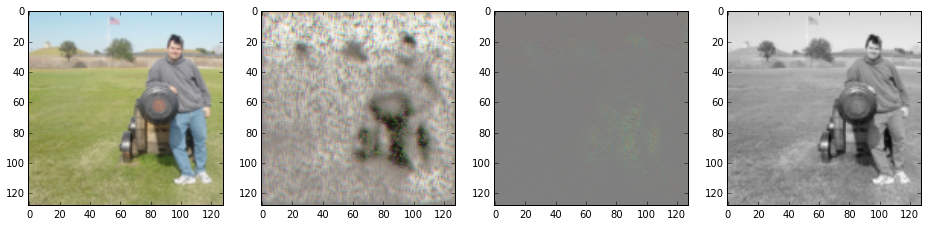

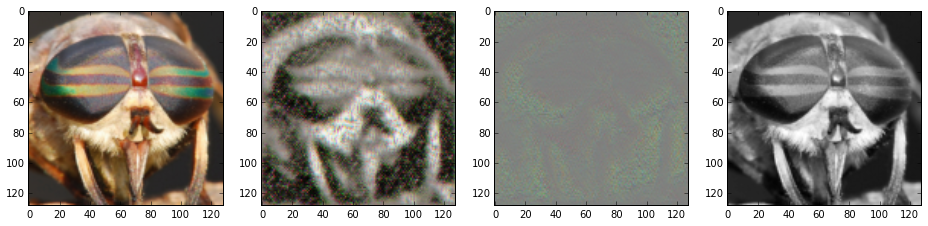

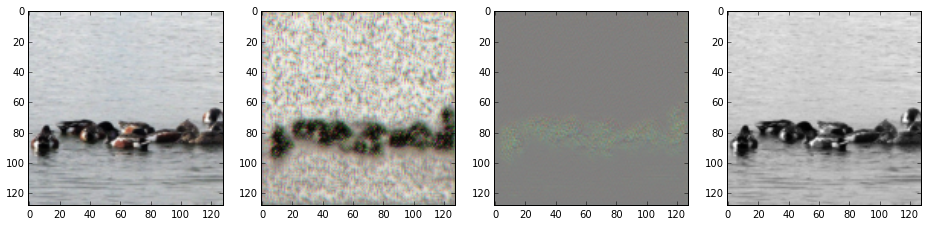

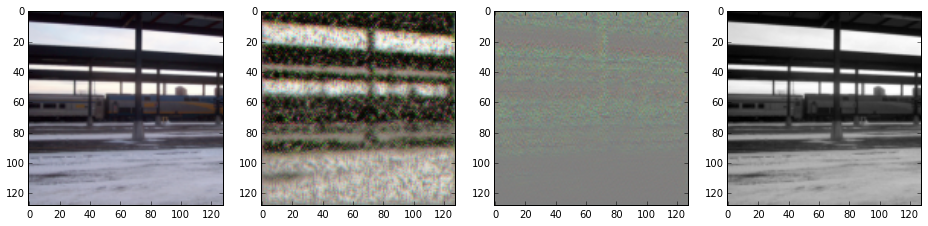

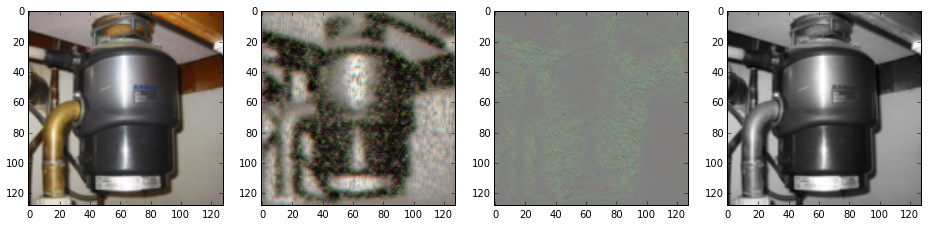

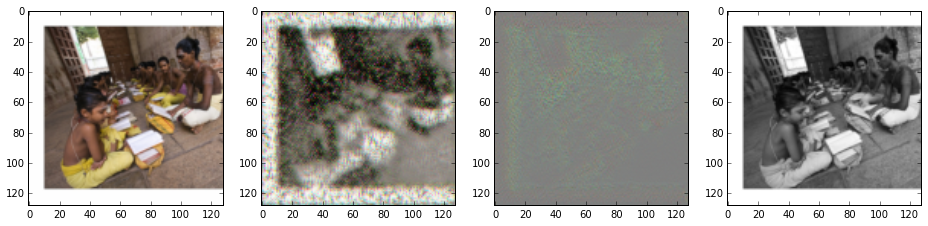

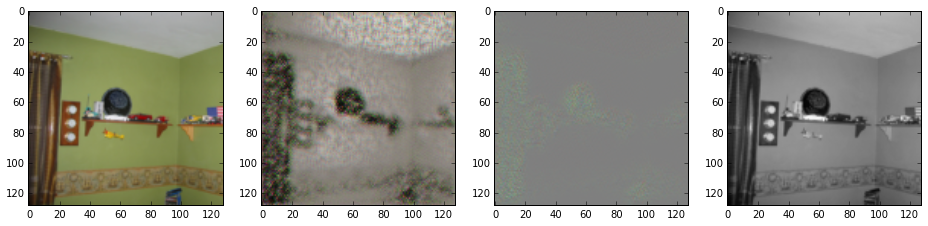

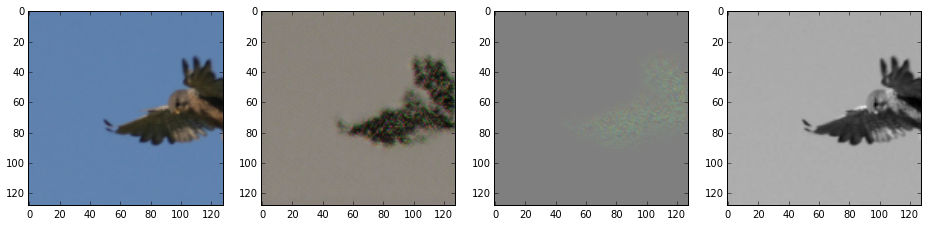

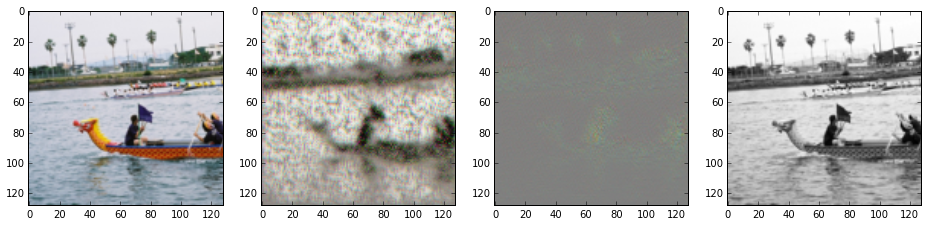

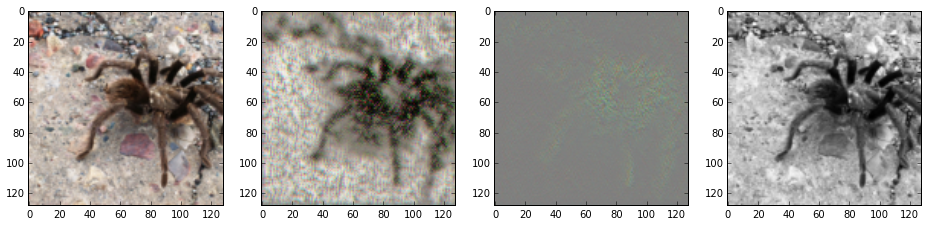

In [123]:
from matplotlib import cm
for x in xrange(10):
    recon, target = [im.reshape((128, 128, 3)) for im in evaluator(images[x])]
    gray = convnets.Grayscale((target * 255).reshape(1, 128, 128, 3)).reshape(128, 128)
    untrained_recon = untrained_evaluator(images[x])[0].reshape((128, 128, 3))
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
    ax0.imshow(target)
    ax1.imshow(recon)
    ax2.imshow(untrained_recon)
    ax3.imshow(gray, cmap=cm.gray)
    plt.show()
    